### Libraries

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector


# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ( AdaBoostClassifier,
                                GradientBoostingClassifier,
                                BaggingClassifier,
                                RandomForestClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Metric scores
from sklearn.metrics import (f1_score,
                            accuracy_score,
                            recall_score,
                            precision_score,
                            confusion_matrix,
                            roc_auc_score,
                            plot_confusion_matrix,
                            classification_report
)


# To impute missing values and handle modeling
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# To supress warnings
import warnings

warnings.filterwarnings("ignore")

### Import Data

In [2]:
# read in the data
bank_churn= pd.read_csv('/Users/tinapham/Desktop/lighthouse-data-notes/ProJect/LHL_FinalProject/Data/BankChurners.csv')


#### Data Dictionary
![Alt text](data_dictionary.png)

### Data Preprocessing

####                    Drop Irrelavant column

In [3]:
# Drop ['CLIENTNUM']
bank_churn= bank_churn.drop(columns='CLIENTNUM')
# Drop the last 2 columns in the DataFrame
bank_churn = bank_churn.iloc[:, :-2]
# Checking the DataFrame
bank_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [4]:
# Filter out data categorical data
category=bank_churn.select_dtypes(exclude=np.number)
# Drop categorical feature
numerical= bank_churn.drop(columns=category)

### Data Cleaning

- Unknown data in object datatype but does not contribute to any missing data in numerical data. The unknown category will be kept as is.
- Outlier observe from distribution plot in EDA:
    - ['Total_Amt_Chng_Q4_Q1']>=2.5
    - ['Total_Ct_Chng_Q4_Q1']>=2.7
    - ['Total_Trans_Ct']>=135
- To be remove in data preprocessing prior to modeling

In [5]:
# Create a model data frame and removing outlier
model_df= bank_churn.copy()
model_df= model_df[model_df['Total_Amt_Chng_Q4_Q1']<=2.5]
model_df= model_df[model_df['Total_Ct_Chng_Q4_Q1']<=2.7]
model_df= model_df[model_df['Total_Trans_Ct']<=135]

print('Number of data for modeling:',model_df.shape[0])

Number of data for modeling: 10115


### Data Preprocessig

In [6]:
# Set target and encoding y
y= model_df['Attrition_Flag'].replace(to_replace={'Attrited Customer': 1, 'Existing Customer': 0})
# Drop target variable and with no significant different in EDA
drop_column= ['Attrition_Flag','Months_on_book', 'Dependent_count','Avg_Open_To_Buy', 'Total_Trans_Ct']
X = model_df.drop(columns=drop_column)

In [7]:
# set dummy variables to categorical data
X = pd.get_dummies(
    data=X,
    columns=[
        "Gender",
        "Education_Level",  # has missing values
        "Marital_Status",  # has missing val
        "Income_Category",
        "Card_Category",
    ],
    drop_first=True,
)

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10115 entries, 0 to 10126
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer_Age                    10115 non-null  int64  
 1   Total_Relationship_Count        10115 non-null  int64  
 2   Months_Inactive_12_mon          10115 non-null  int64  
 3   Contacts_Count_12_mon           10115 non-null  int64  
 4   Credit_Limit                    10115 non-null  float64
 5   Total_Revolving_Bal             10115 non-null  int64  
 6   Total_Amt_Chng_Q4_Q1            10115 non-null  float64
 7   Total_Trans_Amt                 10115 non-null  int64  
 8   Total_Ct_Chng_Q4_Q1             10115 non-null  float64
 9   Avg_Utilization_Ratio           10115 non-null  float64
 10  Gender_M                        10115 non-null  uint8  
 11  Education_Level_Doctorate       10115 non-null  uint8  
 12  Education_Level_Graduate        

### Modeling

#### Split data
- With imbalance in class from target value, with 16.1% attrited customer, K-fold stratified validiation will be included to consider for class imbalance
- Split data into 3 set:
    - test set
    - train set
    - validation set

In [9]:
# Split data into training and test set
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Split training dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.25, random_state=42, stratify=y_training)


In [10]:
datasets = {
    'Train Data': y_train,
    'Validation Data': y_val,
    'Test Data': y_test
}

for dataset_name, data in datasets.items():
    value_counts = data.value_counts(normalize=True)
    print(f"Value counts for {dataset_name}:\n{value_counts}\n{'='*40}\n")

Value counts for Train Data:
0    0.839018
1    0.160982
Name: Attrition_Flag, dtype: float64

Value counts for Validation Data:
0    0.839348
1    0.160652
Name: Attrition_Flag, dtype: float64

Value counts for Test Data:
0    0.839348
1    0.160652
Name: Attrition_Flag, dtype: float64



In [11]:
# Standardize Data
scaler= StandardScaler()
X_train_std= scaler.fit_transform(X_train)


In [12]:
X_val_std= scaler.transform(X_val)
X_test_std= scaler.transform(X_test)

### Model Selection

In [44]:
# Define models
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('SVM', SVC()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Naive Bayes Classifier', GaussianNB()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('XGBoost', GradientBoostingClassifier()))

# Model Evaluation 
acc_results = []
auc_results = []
recall_results= []
#cross_val_score_train=[]
names = []

# Dataframe of results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD', 'Recall Mean', 'Recall STD']
model_results = pd.DataFrame(columns=col)
i = 0
# K-fold validation of model
for name, model in models:
    kfold = StratifiedKFold(n_splits=10)
    # accuracy:
    cv_acc_results = cross_val_score(model, X_train_std, y_train, cv = kfold, scoring = 'accuracy')
    # recall:
    cv_recall_results = cross_val_score(model, X_train_std, y_train, cv = kfold, scoring = 'recall')
    # roc_auc:
    cv_auc_results = cross_val_score(model, X_train_std, y_train, cv = kfold, scoring = 'roc_auc')
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    model_results.loc[i] = [name, round(cv_auc_results.mean()*100, 2), round(cv_auc_results.std()*100, 2),
                            round(cv_acc_results.mean()*100, 2), round(cv_acc_results.std()*100, 2),
                            round(cv_recall_results.mean()*100, 2),round(cv_recall_results.std()*100, 2) ]
    i += 1
    
model_results.sort_values(by=['ROC AUC Mean'], ascending=False)


,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD,Recall Mean,Recall STD
6,XGBoost,98.19,0.46,94.99,0.78,76.87,3.97
5,Random Forest,97.60,0.70,94.27,0.84,70.92,5.10
1,SVM,88.64,1.08,89.49,0.68,41.55,3.16
4,Decision Tree Classifier,84.98,2.32,92.11,0.96,75.54,4.21
0,Logistic Regression,84.78,1.99,88.53,1.04,42.47,3.82
3,Naive Bayes Classifier,80.19,2.11,85.53,1.18,49.23,4.47
2,KNN,76.20,2.44,86.04,0.92,25.08,3.79


- XGboost is the best model

### Model Training

In [124]:
#=========================================================================
# XGBoost Classification: 
# Parameters: 
# n_estimators      "Number of gradient boosted trees. Equivalent to number 
#                   of boosting rounds."
# learning_rate     "Boosting learning rate (also known as “eta”)"
# max_depth         "Maximum depth of a tree. Increasing this value will make 
#                   the model more complex and more likely to overfit." 
# scale_pos_weight  "Penalty for misclassification of the minority class,
#                   to improve the performance on imbalanced dataset"
# gamma             "Regularization parameter that controls the number of 
#                   splits within a tree to reduce overfitting"
# reg_lambda        "Regularization parameter to prevent overfitting by 
#                   penalizing large weights in the model"
#=========================================================================
classifier = XGBClassifier(eval_metric=recall_score)


##### Base Model

In [139]:
xgb= XGBClassifier(eval_metric=recall_score)
xgb.fit(X_train_std, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function recall_score at 0x15d0e0160>,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [148]:
training_pred= xgb.predict(X_train_std)

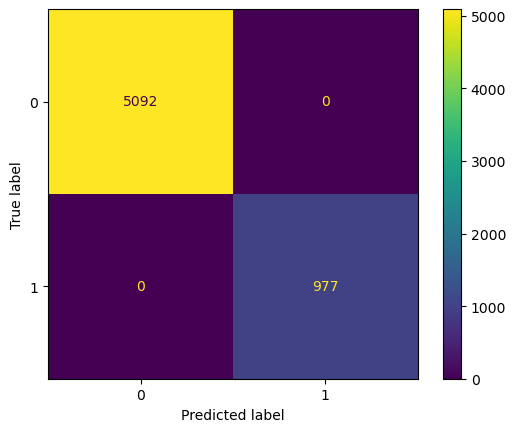

In [150]:
plot_confusion_matrix(xgb, X_train_std,y_train)

In [154]:
target_names= ['Existing','Attrited']
print(classification_report(y_train, training_pred, target_names=target_names))

              precision    recall  f1-score   support

    Existing       1.00      1.00      1.00      5092
    Attrited       1.00      1.00      1.00       977

    accuracy                           1.00      6069
   macro avg       1.00      1.00      1.00      6069
weighted avg       1.00      1.00      1.00      6069



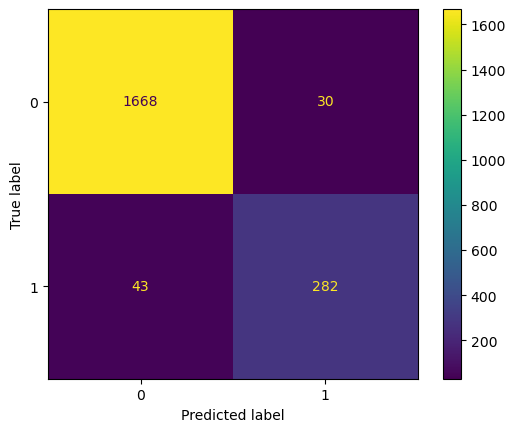

In [155]:
plot_confusion_matrix(xgb, X_val_std,y_val)

In [144]:
target_names= ['Existing','Attrited']
print(classification_report(y_val, prediction_val, target_names=target_names))

              precision    recall  f1-score   support

    Existing       0.97      0.98      0.98      1698
    Attrited       0.90      0.87      0.89       325

    accuracy                           0.96      2023
   macro avg       0.94      0.93      0.93      2023
weighted avg       0.96      0.96      0.96      2023



#### Tuning Model

In [126]:
#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
# set up our search grid
param_randomized={'n_estimators':np.arange(50,500,50),
            'learning_rate':[0.01,0.1,0.2,0.05],
            'scale_pos_weight':[2,5,10],
            'gamma':[0,1,3,5],
            'subsample':[0.5,0.8,0.9,1],
            'max_depth':np.arange(4,20,1),
            'reg_lambda':[5,10, 15, 20]}

In [127]:
# Use random search to tune the model
search = RandomizedSearchCV(classifier, param_randomized,n_iter=50, cv=10).fit(X_train_std, y_train)
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'subsample': 0.9, 'scale_pos_weight': 2, 'reg_lambda': 15, 'n_estimators': 350, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0}


In [128]:
xgb_1= XGBClassifier( learning_rate = search.best_params_["learning_rate"], 
                    n_estimators  = search.best_params_["n_estimators"], 
                    max_depth= search.best_params_["max_depth"],
                    scale_pos_weight= search.best_params_["scale_pos_weight"],
                    gamma= search.best_params_["gamma"],
                    subsample= search.best_params_["subsample"],
                    reg_lambda= search.best_params_["reg_lambda"],
                    eval_metric=accuracy_score)

In [129]:
xgb_1.fit(X_train_std, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function accuracy_score at 0x15d0d9940>,
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=350, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [130]:
training_prediction= xgb_1.predict(X_train_std)

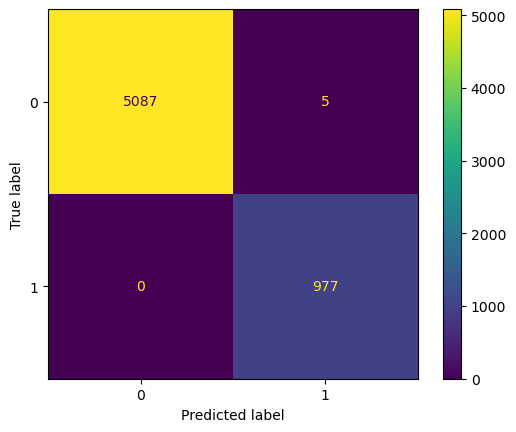

In [131]:
plot_confusion_matrix(xgb_1, X_train_std,y_train)

In [132]:
target_names= ['Existing','Attrited']
print(classification_report(y_train, training_prediction, target_names=target_names))

              precision    recall  f1-score   support

    Existing       1.00      1.00      1.00      5092
    Attrited       0.99      1.00      1.00       977

    accuracy                           1.00      6069
   macro avg       1.00      1.00      1.00      6069
weighted avg       1.00      1.00      1.00      6069



In [133]:
predictions_1 = xgb_1.predict(X_val_std)
predictions


array([0, 0, 0, ..., 1, 0, 0])

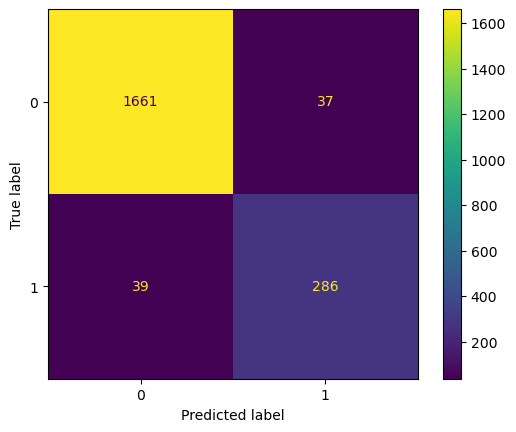

In [134]:
plot_confusion_matrix(xgb_1, X_val_std,y_val)

In [135]:
target_names= ['Existing','Attrited']
print(classification_report(y_val, predictions_1, target_names=target_names))

              precision    recall  f1-score   support

    Existing       0.98      0.98      0.98      1698
    Attrited       0.89      0.88      0.88       325

    accuracy                           0.96      2023
   macro avg       0.93      0.93      0.93      2023
weighted avg       0.96      0.96      0.96      2023



##### Gridsearch tuning

In [156]:
#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
# set up our search grid
param_grid = {"max_depth":[3, 4, 5],
             "n_estimators": [200, 300, 500, 600, 700],
            "learning_rate": [0.01, 0.1, 0.2]}


In [158]:
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='recall').fit(X_train_std, y_train)
print("The best hyperparameters are ",grid_search.best_params_)

The best hyperparameters are  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500}


In [162]:
xgb_2= XGBClassifier(learning_rate = grid_search.best_params_["learning_rate"], 
                        n_estimators  = grid_search.best_params_["n_estimators"], 
                        max_depth= grid_search.best_params_["max_depth"],eval_metric=recall_score)

In [163]:
xgb_2.fit(X_train_std, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function recall_score at 0x15d0e0160>,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [164]:
training_prediction_2= xgb_2.predict(X_train_std)

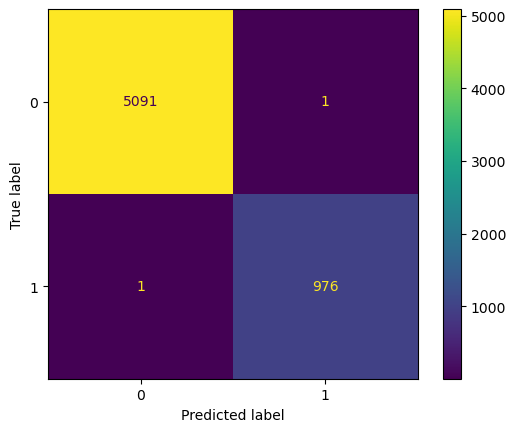

In [165]:
plot_confusion_matrix(xgb_2, X_train_std,y_train)

In [167]:
target_names= ['Existing','Attrited']
print(classification_report(y_train, training_prediction_2, target_names=target_names))

              precision    recall  f1-score   support

    Existing       1.00      1.00      1.00      5092
    Attrited       1.00      1.00      1.00       977

    accuracy                           1.00      6069
   macro avg       1.00      1.00      1.00      6069
weighted avg       1.00      1.00      1.00      6069



In [168]:
prediction_2= xgb_2.predict(X_val_std)

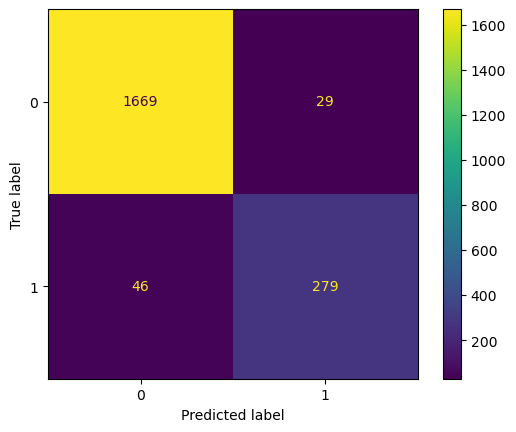

In [169]:
plot_confusion_matrix(xgb_2, X_val_std,y_val)

In [170]:
target_names= ['Existing','Attrited']
print(classification_report(y_val, prediction_2, target_names=target_names))

              precision    recall  f1-score   support

    Existing       0.97      0.98      0.98      1698
    Attrited       0.91      0.86      0.88       325

    accuracy                           0.96      2023
   macro avg       0.94      0.92      0.93      2023
weighted avg       0.96      0.96      0.96      2023



- With a high class imbalance, should go with the model with the higher recall. Hyperparameter tuning from randomized search yield a better result for recall.
- Base model and Grid search model is overfitting to generalize the data set.

- Save model as joblib
- create a script for model inferencing 
- wrap up in flask api and serve it

### Create a Pipeline for model production

In [ ]:
# Define the pipeline steps
steps = [
    ('scaler', StandardScaler()),  # StandardScaler for feature scaling
    ('xgb', XGBClassifier())       # XGBoost classifier
]

# Create the pipeline
xgb_pipeline = Pipeline(steps)

# Fit the pipeline on your training data
xgb_pipeline.fit(X_train, y_train)

# Predict using the fitted pipeline
y_pred = xgb_pipeline.predict(X_test)

# Evaluate the pipeline's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

### Save Model

In [173]:
# Save the trained model to a file
with open('bank_churn_predict.pkl', 'wb') as file:
    pickle.dump(xgb_1, file)

In [174]:
# Load the saved model from file
with open('bank_churn_predict.pkl', 'rb') as file:
    churn_model = pickle.load(file)

In [177]:
model_prediction=churn_model.predict(X_test_std)

In [178]:
recall_score(y_test, model_prediction)

0.8307692307692308